In [6]:
# Import packages 
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import math
from keras.preprocessing.sequence import TimeseriesGenerator
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import time
import os

In [7]:
#load datafiles using pandas

df_train = pd.read_csv('/home/jay/sag_data_train.csv', index_col="Time", parse_dates=True)
df_train.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138241 entries, 2015-09-15 00:00:00 to 2015-12-20 00:00:00
Data columns (total 6 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Bearing Pressure (kPa)         138240 non-null  float64
 1   Power Draw (MW)                138240 non-null  float64
 2   Speed (RPM)                    138241 non-null  float64
 3   Dilution Flow Rate (m3/h)      138239 non-null  float64
 4   Conveyor Belt Feed Rate (t/h)  138239 non-null  float64
 5   Conveyor Belt PSD Fines (%)    138239 non-null  float64
dtypes: float64(6)
memory usage: 7.4 MB


In [8]:
#Preprocessing the Dataset for Time Series Analysis

target_cols = ['Bearing Pressure (kPa)', 'Power Draw (MW)']




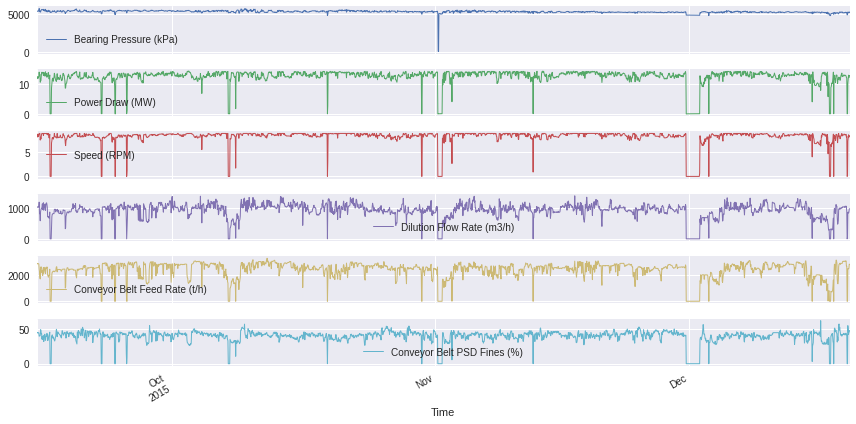

In [9]:
# Plot the all necessary columns to get idea about variance 

df_train.resample("h").median().plot(subplots=True, layout=(-1, 1), lw=1, figsize=(12, 6))
plt.tight_layout()


In [10]:
#Based on plotting, decide the input columns, Here All columns are necessary

df_input = df_train[['Bearing Pressure (kPa)','Power Draw (MW)','Speed (RPM)','Dilution Flow Rate (m3/h)','Conveyor Belt Feed Rate (t/h)','Conveyor Belt PSD Fines (%)']]

#checking the data distribution for input dataframes
df_input.describe()

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
count,138240.000000,138240.000000,138241.000000,138239.000000,138239.000000,138239.000000
mean,5361.525046,12.648002,8.010549,914.572160,2397.461043,39.530702
std,202.317899,2.680285,1.617348,253.075068,667.784116,9.964700
min,35.651295,-0.073347,0.000000,0.000000,0.000000,0.000000
25%,5288.404458,12.442005,8.057497,844.109738,2214.865825,36.440241
50%,5363.159059,13.228316,8.421999,954.845114,2595.094886,41.042423
75%,5450.906468,13.943626,8.677781,1052.036362,2816.975578,44.861298
max,5995.657529,14.965945,8.730035,1636.474899,3594.124010,84.740463


If we get extreme values in above data description then we need to Check for outliers. 

In [11]:
#Use Scaler to transform the data
scaler  = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)


In [12]:
data_scaled

array([[0.9148521 , 0.78532311, 0.89845375, 0.62976225, 0.81679438,
        0.45599253],
       [0.90407268, 0.77245007, 0.87990569, 0.63543281, 0.81475591,
        0.53390853],
       [0.91718146, 0.74756655, 0.86072663, 0.63137981, 0.8121946 ,
        0.45687998],
       ...,
       [0.87662166, 0.89540293, 0.9628629 , 0.57011719, 0.80063273,
        0.47767942],
       [0.87389231, 0.87617836, 0.943823  , 0.58129983, 0.8019716 ,
        0.56591215],
       [0.88024568, 0.87088153, 0.93411875, 0.5934768 , 0.79608029,
        0.56552911]])

We get option to scale data on testing data as well but it is always best practice to apply scaler on train data. 

In [13]:
# Taking features and target variables 
features = data_scaled 
#print(features)
target = data_scaled[:,0:2]
#print(target)

In [14]:
TimeseriesGenerator(features, target, length=1 , sampling_rate = 1, batch_size=128)[0]  #taking 10 minutes as a time length which is 0.5 


(array([[[0.9148521 , 0.78532311, 0.89845375, 0.62976225, 0.81679438,
          0.45599253]],
 
        [[0.90407268, 0.77245007, 0.87990569, 0.63543281, 0.81475591,
          0.53390853]],
 
        [[0.91718146, 0.74756655, 0.86072663, 0.63137981, 0.8121946 ,
          0.45687998]],
 
        [[0.91312177, 0.73862769, 0.86966992, 0.63250318, 0.8306616 ,
          0.50578792]],
 
        [[0.91818057, 0.76414331, 0.891737  , 0.63685022, 0.80827821,
          0.5962269 ]],
 
        [[0.91470002, 0.78228411, 0.90961212, 0.63145707, 0.81996625,
          0.55885185]],
 
        [[0.91352575, 0.78109725, 0.89392086, 0.63835588, 0.80375254,
          0.46091366]],
 
        [[0.91404768, 0.76887056, 0.87915984, 0.62267071, 0.83707353,
          0.52726373]],
 
        [[0.91468613, 0.77650401, 0.89835775, 0.6357827 , 0.80476932,
          0.53208443]],
 
        [[0.90909939, 0.78845353, 0.90263217, 0.63765717, 0.83192192,
          0.57613885]],
 
        [[0.91392408, 0.78067132, 0.8916

In [15]:
#divide the dataset into training and testing 
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 123, shuffle= False)

#Note : Here shuffle = False is compulsory because in timeseries datasets, order of data is very important. So if you don't define it to False then it would take automatically True and shuffle the data.  

In [16]:
x_train.shape

(110592, 6)

In [17]:
x_test.shape

(27649, 6)

In [20]:
#Defining the actual timeseries generator which is we are feeding to the model

win_length = 27648

#Calculation of time window length  : we get data every 5 minute :So we get 12 data points every hour, and for almost 95 days we get this amount of data points. 

batch_size = 100

num_features = 6  # Input size

train_generator = TimeseriesGenerator(x_train, y_train, length= win_length, sampling_rate = 1, batch_size = batch_size)
test_generator = TimeseriesGenerator(x_test,y_test, length=win_length, sampling_rate= 1, batch_size=batch_size)

In [21]:
#Run timeseries generator

train_generator[0]

(array([[[0.9148521 , 0.78532311, 0.89845375, 0.62976225, 0.81679438,
          0.45599253],
         [0.90407268, 0.77245007, 0.87990569, 0.63543281, 0.81475591,
          0.53390853],
         [0.91718146, 0.74756655, 0.86072663, 0.63137981, 0.8121946 ,
          0.45687998],
         ...,
         [0.91005313, 0.80404571, 0.91751775, 0.58503651, 0.86396916,
          0.56078867],
         [0.90830232, 0.80381015, 0.91758237, 0.58144896, 0.85421018,
          0.6352558 ],
         [0.9117088 , 0.8002219 , 0.91764699, 0.58571463, 0.86941073,
          0.59366061]],
 
        [[0.90407268, 0.77245007, 0.87990569, 0.63543281, 0.81475591,
          0.53390853],
         [0.91718146, 0.74756655, 0.86072663, 0.63137981, 0.8121946 ,
          0.45687998],
         [0.91312177, 0.73862769, 0.86966992, 0.63250318, 0.8306616 ,
          0.50578792],
         ...,
         [0.90830232, 0.80381015, 0.91758237, 0.58144896, 0.85421018,
          0.6352558 ],
         [0.9117088 , 0.8002219 , 0.917

In [23]:
#Define the LSTM model architecture 
#

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape = (win_length,num_features), return_sequences=True))
# return_sequence is true because you need hidden state of input data, if it is false then it gives only one state. But here for timeseries data we need each and every state of input sequences. 
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128,return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))    # This is necessary to make sure your model is not overfit 
model.add(tf.keras.layers.LSTM(64, return_sequences=False)) 
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))     #Gives final output state of next hour based on input data 


In [54]:
model.summary()   #it gives summary of my model 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 27648, 128)        69120     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 27648, 128)        0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 27648, 128)        131584    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 27648, 128)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 27648, 128)        0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)              

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience =2, mode = 'min')   #it is conditions to stop the model for iternal training process 

model.compile(loss=tf.losses.MeanSquaredError(), optimizer = tf.optimizers.Adam(),metrics = [tf.metrics.MeanAbsoluteError()])   # Choose the opimizers and loss function

history = model.fit_generator(train_generator,epochs=500, validation_data=test_generator, shuffle=False, callbacks=[early_stopping])


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/500


In [ ]:
model.evaluate_generator(test_generator,verbose = 0 )    # model training phase which need high computing power


In [4]:
predictions = model.predict_generator(test_generator)    # performs on test data 

NameError: name 'model' is not defined

In [ ]:
prediction.shape()  # this numbers we get less amount equal to our time length. 

# After training we have to concat the train and test predictions by ignoring the time length value and get one final pandas dataframe.  The values will be in scaler form so we need to use reverse traform of that dataframe and get the original values. 





# After getting values we try to plot it and make changes in model and re train the model based on the situation. 

# Due to my laptop configuration limits training of large file couldn't possible and I gave enough time but it just hang my PC fully. Simple machine learning algorithms are not working properly on this data and for complex methods LSTM it needs more computational power. 

# Thank you